## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a **Machine Learning Pipeline**, to **engineer the features** in the data set and **predict** who is more likely to Survive the catastrophe. Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # for visualization
from sklearn.model_selection import train_test_split  # to divide train and test set
from sklearn.preprocessing import StandardScaler  # feature scaling
from sklearn.linear_model import LogisticRegression  # to build the models
from sklearn.metrics import accuracy_score, roc_auc_score  # to evaluate the models
import joblib  # to persist the model and the scaler
pd.pandas.set_option('display.max_columns', None)  # to visualise al the columns in the dataframe

## Prepare the data set

In [2]:
data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


**Replace interrogation marks by NaN values!**

In [3]:
data = data.replace('?', np.nan)

**Retain only the first cabin if more than 1 are available per passenger!**

In [4]:
def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
data['cabin'] = data['cabin'].apply(get_first_cabin)

**Extracts the title (Mr, Ms, etc) from the name variable!**

In [5]:
def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
data['title'] = data['name'].apply(get_title)

**Cast numerical variables as floats!**

In [6]:
data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

**Drop unnecessary variables!**

In [7]:
data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)
data.head()          # display data

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


**Save the data set!**

In [8]:
data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
vars_num = [c for c in data.columns if data[c].dtypes!='O' and c!=target]
vars_cat = [c for c in data.columns if data[c].dtypes=='O']
print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

**First in numerical variables!**

In [11]:
data[vars_num].isnull().mean()

pclass    0.000000
age       0.200917
sibsp     0.000000
parch     0.000000
fare      0.000764
dtype: float64

**Now in categorical variables!**

In [12]:
data[vars_cat].isnull().mean()

sex         0.000000
cabin       0.774637
embarked    0.001528
title       0.000000
dtype: float64

### Determine cardinality of categorical variables

In [13]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

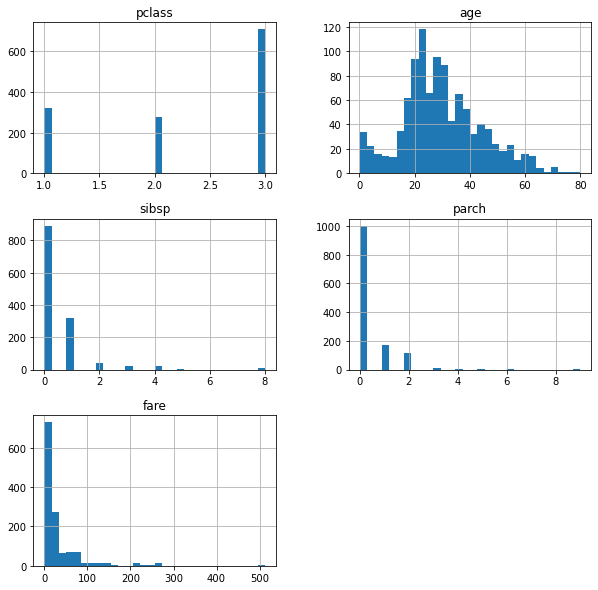

In [14]:
data[vars_num].hist(bins=30, figsize=(10,10))
plt.show()

## Separate data into train and test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility
X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [16]:
X_train['cabin'] = X_train['cabin'].str[0] # captures the first letter
X_test['cabin'] = X_test['cabin'].str[0] # captures the first letter
X_train['cabin'].unique()

array([nan, 'E', 'F', 'A', 'C', 'D', 'B', 'T', 'G'], dtype=object)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

**First add missing indicator! Then replace NaN by median**

In [17]:
for var in ['age', 'fare']:
    X_train[var+'_NA'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_NA'] = np.where(X_test[var].isnull(), 1, 0)
    median_val = X_train[var].median()
    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)
X_train[['age', 'fare']].isnull().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [18]:
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

In [19]:
X_train.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_NA      0
fare_NA     0
dtype: int64

In [20]:
X_test.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_NA      0
fare_NA     0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

**First a function finds the labels that are shared by more than a certain % of the passengers in the dataset!**

In [21]:
def find_frequent_labels(df, var, rare_perc):
    df = df.copy()
    tmp = df.groupby(var)[var].count() / len(df)
    return tmp[tmp > rare_perc].index
for var in vars_cat:  # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    X_train[var] = np.where(X_train[var].isin(  # replace rares by "Rare"
        frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

In [22]:
X_train[vars_cat].nunique()

sex         2
cabin       3
embarked    4
title       4
dtype: int64

In [23]:
X_test[vars_cat].nunique()

sex         2
cabin       3
embarked    3
title       4
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [24]:
for var in vars_cat:
    X_train = pd.concat([X_train,  # to create the binary variables!
                         pd.get_dummies(X_train[var], prefix=var, drop_first=True)
                         ], axis=1)
    X_test = pd.concat([X_test,
                        pd.get_dummies(X_test[var], prefix=var, drop_first=True)
                        ], axis=1)
X_train.drop(labels=vars_cat, axis=1, inplace=True)
X_test.drop(labels=vars_cat, axis=1, inplace=True)
X_train.shape, X_test.shape

((1047, 16), (262, 15))

Note that we have **one less column in the test set**, this is because we had **1 less category in embarked**. we need to **add that category manually** to the test set**

In [25]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_NA,fare_NA,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,0,1,1,0,0,0,1,1,0,0
44,1,41.0,0,0,134.5000,0,0,0,0,1,0,0,0,0,0,0
1072,3,28.0,0,0,7.7333,1,0,1,1,0,1,0,0,1,0,0
1130,3,18.0,0,0,7.7750,0,0,0,1,0,0,0,1,0,0,0
574,2,29.0,1,0,21.0000,0,0,1,1,0,0,0,1,1,0,0


In [26]:
X_test.head()

,pclass,age,sibsp,parch,fare,age_NA,fare_NA,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare
1139,3,38.0,0,0,7.8958,0,0,1,1,0,0,1,1,0,0
533,2,21.0,0,1,21.0000,0,0,0,1,0,0,1,0,0,0
459,2,42.0,1,0,27.0000,0,0,1,1,0,0,1,1,0,0
1150,3,28.0,0,0,14.5000,1,0,1,1,0,0,1,1,0,0
393,2,25.0,0,0,31.5000,0,0,1,1,0,0,1,1,0,0


**Add 0 as values for all the observations, as Rare was not present in the test set!**

In [27]:
X_test['embarked_Rare'] = 0

**Note that now embarked_Rare will be at the end of the test set, so in order to pass the variables in the same order, we will create a variables variable:**

In [28]:
variables = [c  for c in X_train.columns]
variables

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'age_NA',
 'fare_NA',
 'sex_male',
 'cabin_Missing',
 'cabin_Rare',
 'embarked_Q',
 'embarked_Rare',
 'embarked_S',
 'title_Mr',
 'title_Mrs',
 'title_Rare']

### Scale the variables

- Use the standard scaler from Scikit-learn

In [29]:
scaler = StandardScaler()          # create scaler
scaler.fit(X_train[variables])     #  fit the scaler to the train set
X_train = scaler.transform(X_train[variables])  # transform the train and test set
X_test = scaler.transform(X_test[variables])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

**Set up the model! Remember to set the random_state / seed!**

In [30]:
model = LogisticRegression(C=0.0005, random_state=0)
model.fit(X_train, y_train)  # train the model

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

**M**

In [31]:
# make predictions for test set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8431723338485316
train accuracy: 0.7125119388729704

test roc-auc: 0.8354012345679012
test accuracy: 0.7022900763358778



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**